# 偏差和方差

In [38]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
def load_data():
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']] )

用 map 的“聪明办法”：你告诉 map 两个东西：
用什么工具：np.ravel（拍扁锤子）
要处理谁：[...]（那堆数据）
意思就是： “把 np.ravel 这个操作，映射 (map) 到列表里的每一个元素上去。”

In [40]:
X, y, Xval, yval, Xtest, ytest = load_data()   
# X:训练集(学习知识)
# Xval:交叉验证集(模拟考)
# Xtest:测试集(期末考)

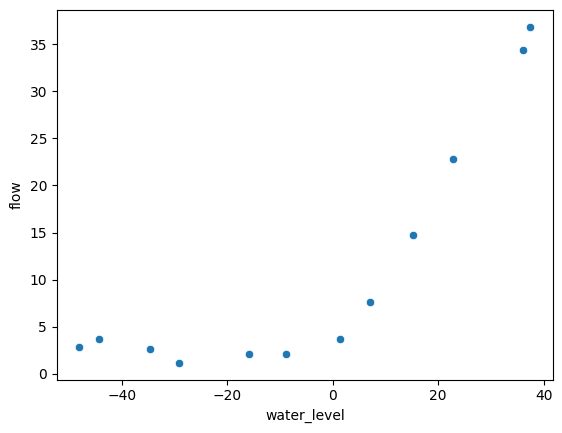

In [41]:
df = pd.DataFrame({'water_level': X, 'flow' : y})

sns.scatterplot(x = df['water_level'] , y = df['flow'])
plt.show()

In [42]:
X = np.insert( X.reshape(len(X),1), 0 , np.ones(len(X)) , axis = 1)
Xval = np.insert( Xval.reshape(len(Xval),1), 0 , np.ones(len(Xval)) , axis = 1)
Xtest = np.insert( Xtest.reshape(len(Xtest),1), 0 , np.ones(len(Xtest)) , axis = 1)  

# 代价函数

代价函数公式：
$$J(\theta)=\frac{1}{2m}\sum_{i=1}^m\left(h_{\theta}(x^{(i)})-y^{(i)}\right)^2$$

In [43]:
def cost(theta, X, y):

    m = X.shape[0]

    # inner = X @ theta - y  # R(m*1)

    # square_sum = inner.T @ inner
    # cost = square_sum / (2 * m)

    inner = X @ theta - y
    inner = np.power(inner,2)
    return np.sum(inner) / (2 * m )

    return cost

In [44]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

# 输出值约为 303.951

np.float64(303.9515255535976)

# 正则化代价函数

正则化代价函数公式：
$$J(\theta)=\frac{1}{2m}\left(\sum_{i=1}^m\left(h_{\theta}(x^{(i)})-y^{(i)}\right)^2\right) + \dfrac{\lambda}{2m}\left(\sum_{j=1}^n \theta_j^2\right)$$

In [45]:
def regularized_cost(theta, X, y, lamda=1):


    m = X.shape[0]

    inner = X @ theta - y  # R(m*1)
    
    cost = (inner.T @ inner) / (2 * m) 

    reg = np.sum(np.power(theta[1:],2)) * lamda / (2 * m)

    return cost + reg

In [46]:
theta = np.ones(X.shape[1])
regularized_cost(theta, X, y)

# 输出值约为 303.993

np.float64(303.9931922202643)

# 梯度

$$\begin{aligned}{{\theta }_{j}} &:={{\theta }_{j}}-\alpha \frac{\partial }{\partial {{\theta }_{j}}}J\left( \theta  \right) \\ &:= {{\theta }_{j}}-\alpha \frac{1}{m} \sum^{m}_{i=1}\left( h_\theta \left(x^{(i)}\right) -y^{(i)}  \right)x^{(i)}_j \end{aligned}$$
注意：对于所有的$j$，需要同时更新$\theta_j$。

In [47]:
def gradient(theta, X, y):
    m = X.shape[0]
    
    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)

    return inner / m

In [48]:
gradient(theta, X, y)

# 输出值约为 array([-15.30301567, 598.16741084])

array([-15.30301567, 598.16741084])

# 正则化梯度

正则化梯度公式：
$$
\begin{align*}
&\dfrac {\partial J(\theta)}{\partial \theta _{0}} = \dfrac{1}{m} \sum_{i=1}^m \left(h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)} & \text{for } j=0 \\
&\dfrac {\partial J(\theta)}{\partial \theta _{0}} = \left(\dfrac{1}{m} \sum_{i=1}^m \left(h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)}\right) + \dfrac{\lambda}{m}\theta_j & \text{for } j \ge 1
\end{align*}
$$

In [ ]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]
    reg  = theta.copy()
    reg[0] = 0
    reg = (l/m) * reg 
    return reg + gradient(theta , X , y)
   # return gradient(theta, X, y) + regularized_term

In [50]:
regularized_gradient(theta, X, y)

# 输出值约为 array([ -15.30301567,  598.25074417])

array([-15.30301567, 598.25074417])

# 拟合数据
> 正则化项 $\lambda=0$

In [ ]:
def linear_regression_np(X, y, l=1):


    theta = np.ones(X.shape[1])

    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       )    
    return res

In [ ]:
final_theta = linear_regression_np(X, y, 0).get('x')

12


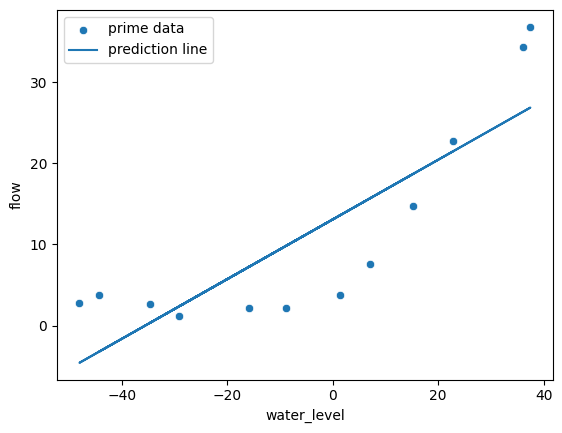

In [66]:
b = final_theta[0] # intercept
m = final_theta[1] # slope
sns.scatterplot(x = df['water_level'] , y = df['flow'], label = 'prime data' )
plt.plot(X[:,1], m * X[:,1] + b , label = 'prediction line')
plt.legend()
plt.show()

In [54]:
training_cost, cv_cost = [], []

1.使用训练集的子集来拟合应模型

2.在计算训练代价和交叉验证代价时，没有用正则化

3.记住使用相同的训练集子集来计算训练代价

In [ ]:
m = X.shape[0]
for i in range(1, m+1):
    
    res = linear_regression_np(X[:i, :], y[:i], 0)
    
    # 训练损失函数
    tc = regularized_cost(res.x, X[:i , :], y[:i], 0)
    
    # 交叉验证集的损失函数
    cv = regularized_cost(res.x, Xval, yval, 0)
  
    
    training_cost.append(tc)
    cv_cost.append(cv)

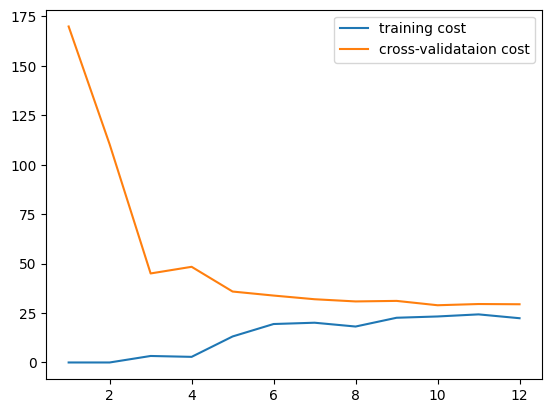

In [74]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cross-validataion cost')
plt.legend()
plt.show()

这个模型拟合不太好, **欠拟合了**

# 创建多项式特征

In [98]:
def prepare_poly_data(df, power):
    t = poly_features(df,power)
    t = normalize_feature(t).values
    t = np.insert(t,0,np.ones(t.shape[0]),axis = 1)
    return t

In [96]:
def poly_features(x,power, ndarray_is = False):
    T = {}
    for i in range(0,power):
        d = np.power(x,i+1)
        col = f'f{i+1}'
        T[col] = d
    df = pd.DataFrame(T)
    if ndarray_is :
        return df.values
    else:
        return df

In [99]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [97]:
poly_features(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


# 准备多项式回归数据
1. 扩展特征到 8阶,或者你需要的阶数
2. 使用 **归一化** 来合并 $x^n$ 
3. don't forget intercept term

In [ ]:
def normalize_feature(df):
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [101]:

X_poly = prepare_poly_data(X,8)
Xval_poly = prepare_poly_data(Xval,8)
Xtest_poly = prepare_poly_data(Xtest,8)
X_poly[:3,:]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

# 画出学习曲线
## 尝试不使用正则化 $\lambda=0$

In [104]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]
    for i in range(1, m + 1):
    
        res = linear_regression_np(X[:i, :], y[:i], l=l)

        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')


1. 数学公式对比在绘制学习曲线时，我们定义的 Training Error 和 CV Error 是这样的：$J_{train}(\theta) = \frac{1}{2m_{train}} \sum_{i=1}^{m_{train}}(h_\theta(x^{(i)}) - y^{(i)})^2$ 
$J_{cv}(\theta) = \frac{1}{2m_{cv}} \sum_{i=1}^{m_{cv}}(h_\theta(x_{cv}^{(i)}) - y_{cv}^{(i)})^2$注意： 后面都没有那个尾巴 $\frac{\lambda}{2m}\sum \theta_j^2$。

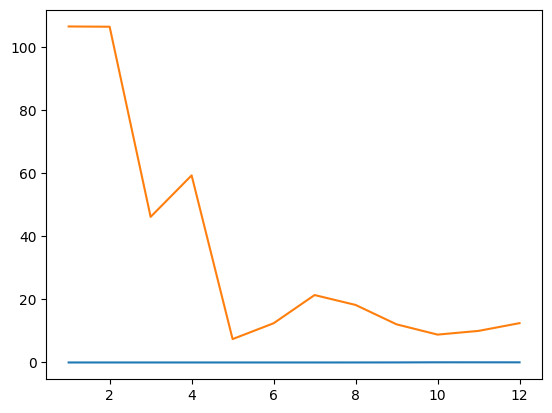

In [105]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

你可以看到训练的代价太低了，不真实. 这是 **过拟合**了

## 尝试 $\lambda=1$

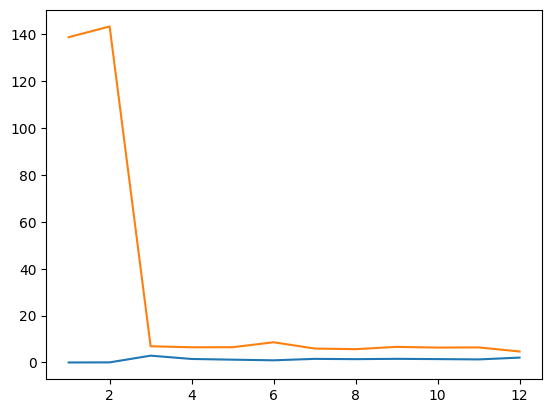

In [106]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

训练代价增加了些，不再是0了，也就是说减轻了**过拟合**

## 尝试 $\lambda=100$

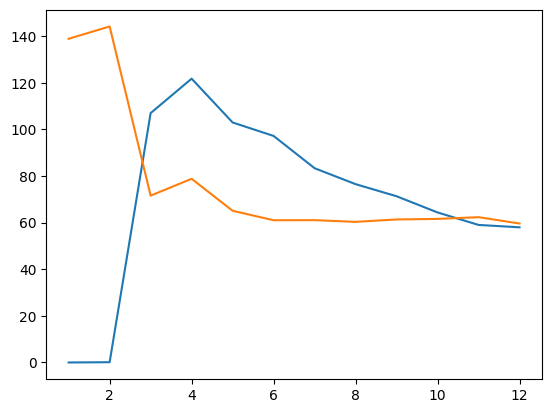

In [107]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

正则化过度了，成了 **欠拟合**状态

## 找到最佳的 $\lambda$

In [110]:
# 尝试一系列的labmda值
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [111]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

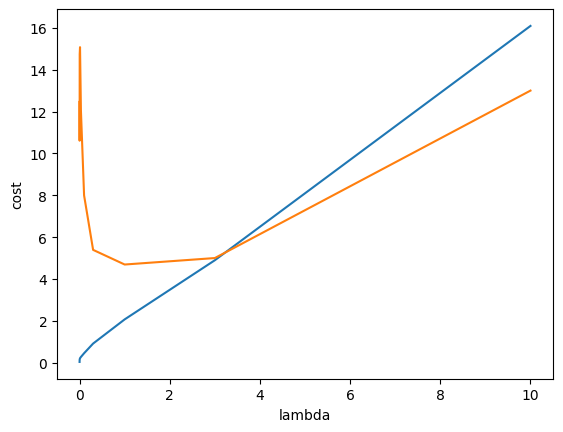

In [112]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [115]:
# 使用cross-validation cost找到最佳的lambda，即cross-validation cost最小时的lambda
l_candidate[np.argmin(cv_cost)]

1

In [116]:
# 使用测试数据来计算 cost
test_cost = []
cnt = 0
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    tc = cost(theta, Xtest_poly, ytest)
    test_cost.append(tc)
    print(f'test: {cnt + 1} , l = {l} , loss = {tc}')
    cnt = cnt + 1

test: 1 , l = 0 , loss = 10.055426362410124
test: 2 , l = 0.001 , loss = 11.001927632262907
test: 3 , l = 0.003 , loss = 11.26474655167747
test: 4 , l = 0.01 , loss = 10.880780731411717
test: 5 , l = 0.03 , loss = 10.022100517865269
test: 6 , l = 0.1 , loss = 8.63190793331871
test: 7 , l = 0.3 , loss = 7.3366077892272585
test: 8 , l = 1 , loss = 7.466283751156784
test: 9 , l = 3 , loss = 11.643941860536106
test: 10 , l = 10 , loss = 27.715080254176254


调参后， $\lambda = 0.3$ 是最优选择，这个时候测试代价最小。
打印出来看看：

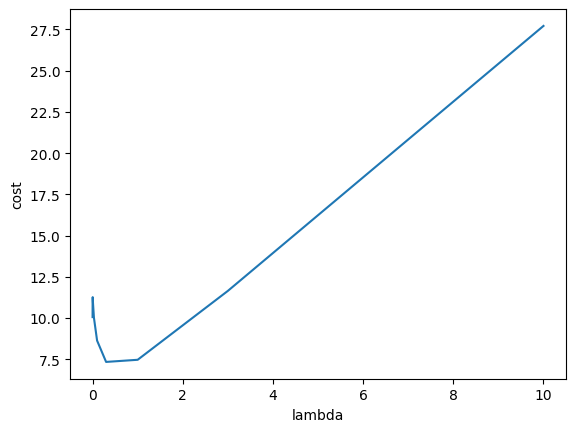

In [118]:
plt.plot(l_candidate, test_cost, label='test')
plt.xlabel('lambda')
plt.ylabel('cost')
plt.show()